# Import required libraries

In [39]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
import re

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Import the dataset and showcase a few samples

In [40]:
songs_df = pd.read_csv('Songs.csv')
songs_df.head()

,Artist,Title,Lyrics
0,Taylor Swift,cardigan,"Vintage tee, brand new phone\nHigh heels on co..."
1,Taylor Swift,exile,"I can see you standing, honey\nWith his arms a..."
2,Taylor Swift,Lover,We could leave the Christmas lights up 'til Ja...
3,Taylor Swift,the 1,"I'm doing good, I'm on some new shit\nBeen say..."
4,Taylor Swift,Look What You Made Me Do,I don't like your little games\nDon't like you...


# Printing the artists names with the number of associated songs

In [41]:
artist_song_count = songs_df['Artist'].value_counts()
print(artist_song_count)

Artist
Taylor Swift          50
David Bowie           50
Billy Joel            50
Eric Clapton          50
Billie Eilish         50
Leonard Cohen         50
Bruce Springsteen     40
The Beatles           35
Ray LaMontagne        30
Elton John            30
Queen                 30
Frank Sinatra         30
John Denver           30
Bryan Adams           30
​twenty one pilots    30
Nat King Cole         30
Lana Del Rey          30
Vance Joy             30
George Michael        30
Bob Dylan             20
Ed Sheeran            20
Name: count, dtype: int64


# Printing the dataset size and the amount of songs

In [42]:
dataset_size = songs_df.shape
total_songs = len(songs_df)
print(f"Dataset size (rows, columns): {dataset_size}")
print(f"Total number of songs: {total_songs}")

Dataset size (rows, columns): (745, 3)
Total number of songs: 745


# Printing the average number of chars and average number of words per song

In [43]:
average_characters = songs_df['Lyrics'].apply(len).mean()
average_words = songs_df['Lyrics'].apply(lambda x: len(x.split())).mean()

print(f"Average number of characters per song: {average_characters}")
print(f"Average number of words per song: {average_words}")

Average number of characters per song: 1403.3476510067114
Average number of words per song: 276.26040268456376


# Visualize the words using word cloud and print the most used words

Top 3 most used words: [('the', 7458), ('I', 6719), ('you', 5475)]


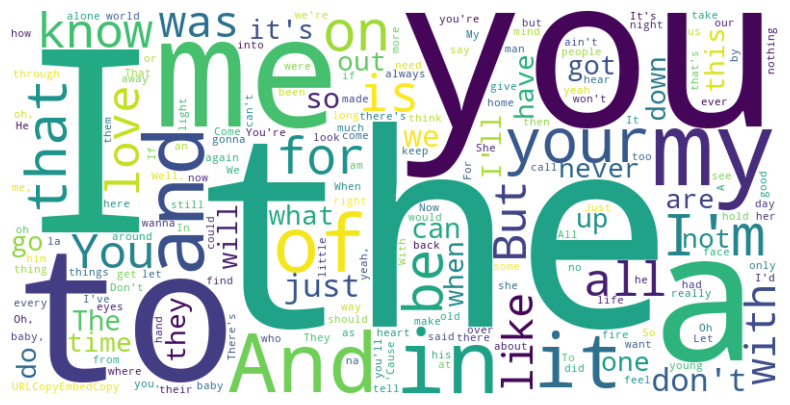

In [44]:
all_lyrics = ' '.join(songs_df['Lyrics'])
word_counts = Counter(all_lyrics.split())
top_3_words = word_counts.most_common(3)
print("Top 3 most used words:", top_3_words)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Preprocessing the data and encoding it

In [45]:
corpus = songs_df['Lyrics'].tolist()

def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    return text

cleaned_corpus = [clean_text(lyrics) for lyrics in corpus]

all_words = ' '.join(cleaned_corpus).split()
vocab = sorted(list(set(all_words)))
word2idx = {word: i+1 for i, word in enumerate(vocab)}
idx2word = {i: word for word, i in word2idx.items()}
vocab_size = len(word2idx) + 1

tokenized_corpus = []
for lyrics in cleaned_corpus:
    tokens = lyrics.split()
    tokenized = [word2idx[word] for word in tokens if word in word2idx]
    tokenized_corpus.append(torch.tensor(tokenized, dtype=torch.long))

input_sequences = []
target_sequences = []
for tokens in tokenized_corpus:
    if len(tokens) < 2:
        continue
    input_sequences.append(tokens[:-1])
    target_sequences.append(tokens[1:])

input_padded = torch.nn.utils.rnn.pad_sequence(input_sequences, batch_first=True, padding_value=0)
target_padded = torch.nn.utils.rnn.pad_sequence(target_sequences, batch_first=True, padding_value=0)

In [46]:
class LyricsLSTM_LM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, n_layers):
        super(LyricsLSTM_LM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
    
    def forward(self, x, hidden=None):
        embedded = self.embedding(x)
        lstm_out, hidden = self.lstm(embedded, hidden)
        output = self.fc(lstm_out)
        return output, hidden

embedding_dim = 128
hidden_dim = 256
n_layers = 2

model = LyricsLSTM_LM(vocab_size, embedding_dim, hidden_dim, n_layers).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [48]:
batch_size = 16
dataset = TensorDataset(input_padded, target_padded)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

num_epochs = 100
training_loss = []

print(f"Using device: {device}")
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs, _ = model(inputs)
        outputs = outputs.reshape(-1, vocab_size)
        targets = targets.reshape(-1)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_loss = epoch_loss / len(dataloader)
    training_loss.append(avg_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')

Using device: cuda


RuntimeError: CUDA out of memory. Tried to allocate 822.00 MiB (GPU 0; 8.00 GiB total capacity; 5.30 GiB already allocated; 346.50 MiB free; 6.09 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

# Plot the loss

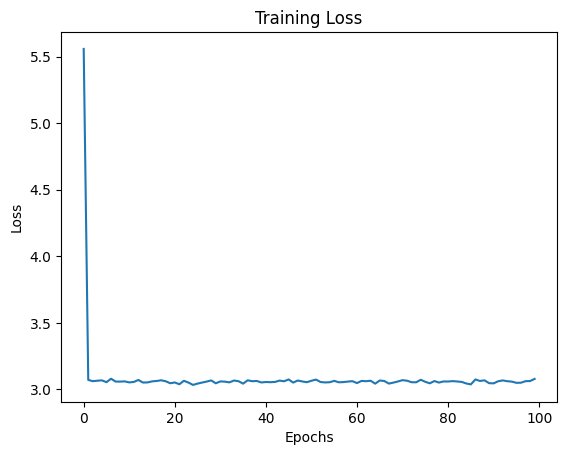

In [38]:
plt.plot(range(num_epochs), training_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()